# Final Project: Understanding Hired Rides in NYC - Group 12

## Project Setup

In [1]:
# all import statements needed for the project
import math
from math import tan, pi
import geopandas
from geopandas import GeoSeries,GeoDataFrame
import os
import re
import bs4
from bs4 import BeautifulSoup as bs
import requests
import urllib3
import pandas as pd
import matplotlib.animation as animation
import matplotlib.pyplot as plt
from keplergl import KeplerGl
import sqlalchemy as db
import numpy as np
import warnings

In [2]:
# any general notebook setup, like log formatting
warnings.filterwarnings("ignore")

In [3]:
# any constants needed for the project:
TAXI_URL = "https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page"
UBER_CSV = "uber_rides_sample.csv"
EARTH_RADIUS = 6378.137
NEW_YORK_BOX_COORDS = ((40.560445, -74.242330), (40.908524, -73.717047))
DATABASE_URL = "sqlite:///project.db"
DATABASE_SCHEMA_FILE = "schema.sql"
QUERY_DIRECTORY = "queries"
#need to download mannually from drive folder
WEATHER_CSV_FILES = ["2009_weather.csv", "2010_weather.csv", "2011_weather.csv", "2012_weather.csv",
                    "2013_weather.csv", "2014_weather.csv", "2015_weather.csv"]

## Part 1: Data Preprocessing

### Calculate Distance
- 1. Define a function that calculates the distance between two coordinates in kilometers that only uses the math module from the standard library
- 2. Use calculate_distance function to add distance column to each Uber and Yellow Taxi dataset

In [4]:
def rad(d):
    """
    Calculate radius of a circle
    
    Arguments:
    d -- diameter
    
    Returns:
    float -- calculated radius
    
    """
    return d * pi / 180.0

def calculate_distance(from_coord, to_coord):
    """
    Calculate distance from two coordinate in longitude and latitude using math
    
    Arguments:
    from_coord -- starting coordinate
    to_coord -- ending coordinate
    
    Returns:
    s -- distance between coordinates
    
    """
    lat1 = from_coord[0]
    lng1 = from_coord[1]
    lat2 = to_coord[0]
    lng2 = to_coord[1]
    radLat1 = rad(lat1)
    radLat2 = rad(lat2)
    a = radLat1 - radLat2
    b = rad(lng1) - rad(lng2)
    s = 2 * math.asin(
        math.sqrt(math.pow(math.sin(a / 2), 2) + math.cos(radLat1) * math.cos(radLat2) * math.pow(math.sin(b / 2), 2)))
    s = s * EARTH_RADIUS
    return s   

In [5]:
def add_distance_column(dataframe):
    """
    Add a column with name 'cal_distance' to a dataframe
    
    Arguments:
    dataframe -- dataframe which contain coordinates
    
    """
    distance_list = []
    for i in range(dataframe.shape[0]):
        s_lat, s_lon  = dataframe["pickup_latitude"][i], dataframe["pickup_longitude"][i]
        e_lat, e_lon  = dataframe["dropoff_latitude"][i], dataframe["dropoff_longitude"][i]
        if s_lat and s_lon and e_lat and e_lon:
            outside = True
            if s_lat > NEW_YORK_BOX_COORDS[0][0] and s_lat < NEW_YORK_BOX_COORDS[1][0]:
                if e_lat > NEW_YORK_BOX_COORDS[0][0] and e_lat < NEW_YORK_BOX_COORDS[1][0]:
                    if s_lon > NEW_YORK_BOX_COORDS[0][1] and s_lon < NEW_YORK_BOX_COORDS[1][1]:
                        if e_lon > NEW_YORK_BOX_COORDS[0][1] and e_lon < NEW_YORK_BOX_COORDS[1][1]:
                            outside = False
            if outside:
                s_lat, s_lon, e_lat, e_lon = None, None, None, None
        from_coord = (s_lat, s_lon)
        to_coord = (e_lat, e_lon)
        if s_lat and s_lon and e_lat and e_lon:
            distance_list.append(calculate_distance(from_coord, to_coord))
        else:
            distance_list.append(None)
    dataframe["cal_distance"] = distance_list

### Convert ID into Coordinates
- 1. Get coordinates using the “center” of the zones (polygons) 
- 2. Convert ID into coordinates
- 3. Only include trips that have valid location IDs 
- 4. Only include trips that start and/or end outside of the NEW_YORK_BOX_COORDS


In [6]:
def get_lat_lon_from_loc():
    """
    Read coordinate in 'taxi_zones.shp' using geopandas
    
    Returns:
    gdf -- a geopandas object contains reference between coordinate and taxi area ID
    
    """
    gdf = geopandas.read_file("taxi_zones.shp")
    gdf = gdf.to_crs(4326)
    lon = gdf.centroid.x
    lat = gdf.centroid.y
    gdf["lon"] = lon
    gdf["lat"] = lat
    return gdf

In [7]:
def convert_id_into_lat_lon(all_sample_tables):
    """
    Convert inputs' area ID column into two coordinates
    
    Arguments:
    all_sample_tables -- a dataframe with taxi area ID
    
    """
    gdf = get_lat_lon_from_loc()
    start_lon = []
    start_lat = []
    end_lon = []
    end_lat = []
    id_list = list(gdf["LocationID"])
    for i in range(all_sample_tables.shape[0]):
        s_lat, s_lon, e_lat, e_lon = None, None, None, None
        start_point = all_sample_tables["PULocationID"][i]
        end_point = all_sample_tables["DOLocationID"][i]
        if start_point in id_list and start_point < 264:
            index_location = gdf[ gdf["LocationID"]==start_point ].index.values[0]
            s_lon = float( gdf["lon"][index_location])
            s_lat = float( gdf["lat"][index_location])
        if end_point in id_list and end_point < 264:
            index_location = gdf[ gdf["LocationID"]==end_point ].index.values[0]
            e_lon = float( gdf["lon"][index_location])
            e_lat = float( gdf["lat"][index_location])
        if s_lat and s_lon and e_lat and e_lon:
            outside = True
            if s_lat > NEW_YORK_BOX_COORDS[0][0] and s_lat < NEW_YORK_BOX_COORDS[1][0]:
                if e_lat > NEW_YORK_BOX_COORDS[0][0] and e_lat < NEW_YORK_BOX_COORDS[1][0]:
                    if s_lon > NEW_YORK_BOX_COORDS[0][1] and s_lon < NEW_YORK_BOX_COORDS[1][1]:
                        if e_lon > NEW_YORK_BOX_COORDS[0][1] and e_lon < NEW_YORK_BOX_COORDS[1][1]:
                            outside = False
            if outside:
                s_lat, s_lon, e_lat, e_lon = None, None, None, None
        
        start_lon.append(s_lon)
        start_lat.append(s_lat)
        end_lon.append(e_lon)
        end_lat.append(e_lat)
            
    all_sample_tables["pickup_longitude"] = start_lon
    all_sample_tables["pickup_latitude"] = start_lat
    all_sample_tables["dropoff_longitude"] = end_lon
    all_sample_tables["dropoff_latitude"] = end_lat

### Processing Taxi Data

- 1. Find the desired links of yellow taxi data
- 2. Get and clean month taxi data (sample)
- 3. Remove useless columns
- 4. Process NAN value
- 5. Convert ID into coordinate
- 6. Convert date taxi data into YEAR, MONTH, DAY, HOUR and WEEK
- 7. Get distance column of taxi data
- 8. Generate taxi data (one gigantic dataframe)

In [8]:
def process_datetime(all_sample_tables):
    """
    Change column type for date column and add columns for specific time data
    
    Arguments:
    all_sample_tables -- a dataframe with time data column
    
    """
    if "tpep_pickup_datetime" in all_sample_tables.columns:
        all_sample_tables['tpep_pickup_datetime'] = pd.to_datetime(all_sample_tables['tpep_pickup_datetime'])
        all_sample_tables['tpep_dropoff_datetime'] = pd.to_datetime(all_sample_tables['tpep_dropoff_datetime'])
        all_sample_tables['DATE'] = pd.to_datetime(all_sample_tables['tpep_pickup_datetime'])
        all_sample_tables['YEAR'] = all_sample_tables['tpep_pickup_datetime'].dt.year.astype(int)
        all_sample_tables['MONTH'] = all_sample_tables['tpep_pickup_datetime'].dt.month.astype(int)
        all_sample_tables['DAY'] = all_sample_tables['tpep_pickup_datetime'].dt.day.astype(int)
        all_sample_tables['HOUR'] = all_sample_tables['tpep_pickup_datetime'].dt.hour.astype(int)
        all_sample_tables["WEEK"] = all_sample_tables['tpep_pickup_datetime'].dt.dayofweek+1 # 0-6 to 1-7
    else:
        all_sample_tables['tpep_pickup_datetime'] = None
        all_sample_tables['YEAR'] = None
        all_sample_tables['MONTH'] = None
        all_sample_tables['DAY'] = None
        all_sample_tables['HOUR'] = None
        all_sample_tables["WEEK"] = None 

In [9]:
def find_taxi_parquet_urls():
    """
    Find url for taxi data in parquet file type between 2009-01 and 2015-06
    
    Returns:
    parquet_urls -- a list contains all taxi data url in TAXI_URL
    
    """
    parquet_urls = []
    res = requests.get(url=TAXI_URL)
    soup = bs(res.text)
    for i, link in enumerate(soup.findAll('a')): 
        new_url = link.get('href')
        data_pattern = r'yellow_tripdata_201[012345]|2009'
        if re.search(data_pattern, new_url):
            if not re.search(r'2015\-0[789]|2015\-1[012]', new_url):
                parquet_urls.append(new_url)     
    return parquet_urls

In [10]:
def get_and_clean_month_taxi_data(url):
    """
    Download, read, sample, and clean one month of taxi data
    
    Arguments:
    url -- a url for download a certain month's taxi parquet file
    
    Returns:
    pd_data -- a dataframe that contains cleaned one month taxi data
    
    """
    response = requests.get(url, stream=True)

    file_name = url.split("/")[-1]
    
    # if exists, no need to download
    if not os.path.exists(file_name):
        with open(file_name, 'wb') as f: 
            for chunk in response.iter_content(chunk_size=1024):
                f.write(chunk)

    #Columns name that will be kept in different years' data
    list_11_15 = ["tpep_pickup_datetime", "tpep_dropoff_datetime", "passenger_count", "trip_distance", "pickup_longitude"
                      ,"pickup_latitude", "dropoff_longitude", "dropoff_latitude", "tip_amount"]
    list_10 = ["pickup_datetime", "dropoff_datetime", "passenger_count", "trip_distance","pickup_longitude", "pickup_latitude"
                   , "dropoff_longitude", "dropoff_latitude", "tip_amount"]
    list_09 = ["Trip_Pickup_DateTime", "Trip_Dropoff_DateTime", "Passenger_Count", "Trip_Distance","Start_Lon", "Start_Lat"
                   , "End_Lon", "End_Lat", "Tip_Amt"]
    kept_list = []
    
    pd_data = pd.read_parquet(file_name)
    #get a sample of 10000 as a way to increase process speed (efficiency)
    pd_data = pd_data.sample(10000)
    pd_data = pd_data.reset_index()

    if not re.search(r"2009|2010", file_name):
        convert_id_into_lat_lon(pd_data)
        kept_list = list_11_15
    elif re.search(r"2010", file_name):
        kept_list = list_10
    else:
        kept_list = list_09
        
    #Keep certain columns and unified the names of the column for later use
    pd_data = pd_data[kept_list]
    unified_column_name = {kept_list[i]:list_11_15[i] for i in range(len(kept_list))}
    pd_data.rename(columns=unified_column_name, inplace=True)
    
    #drop rows with invalid data
    pd_data[list_11_15[:8]] = pd_data[list_11_15[:8]].replace(0.0, None)
    pd_data.dropna(inplace=True)

    # sample 2564 for each month since 200,000/78 = 2564
    # make it roughly equal to the sample size of the uber dataset
    pd_data = pd_data.sample(2564)
    pd_data = pd_data.reset_index()           
    
    process_datetime(pd_data)

    add_distance_column(pd_data)
    pd_data.drop(["index"], axis=1,inplace=True)
    return pd_data

In [11]:
def get_and_clean_taxi_data():
    """
    Get and clean taxi data from 2009-01 to 2015-06
    
    Returns:
    taxi_data -- a dataframe contains all taxi data from 2009-01 to 2015-06
    
    """
    all_taxi_dataframes = []
    
    all_parquet_urls = find_taxi_parquet_urls()
    for parquet_url in all_parquet_urls:

        dataframe = get_and_clean_month_taxi_data(parquet_url)
        
        all_taxi_dataframes.append(dataframe)

    # create one gigantic dataframe with data from every month needed
    taxi_data = pd.concat(all_taxi_dataframes)
    return taxi_data

### Processing Uber Data

- 1. Load and clean uber data
- 2. Convert date uber data into YEAR, MONTH, DAY, HOUR and WEEK
- 3. Get distance column of uber data
- 4. Remove useless columns
- 5. Process NAN value
- 6. Genereate uber data

In [12]:
def load_and_clean_uber_data(csv_file):
    """
    Get data from input file name and add date column to it  
    
    Arguments:
    csv_file -- file name contains file need to get
    
    Returns:
    pd_data -- a dataframe that contains data from input file name
    
    """
    pd_data = pd.read_csv(csv_file, index_col=0)
    pd_data['pickup_datetime'] = pd.to_datetime(pd_data['pickup_datetime'])
    pd_data['YEAR'] = pd_data['pickup_datetime'].dt.year.astype(int)
    pd_data['MONTH'] = pd_data['pickup_datetime'].dt.month.astype(int)
    pd_data['DAY'] = pd_data['pickup_datetime'].dt.day.astype(int)
    pd_data['HOUR'] = pd_data['pickup_datetime'].dt.hour.astype(int)
    pd_data["WEEK"] = pd_data['pickup_datetime'].dt.dayofweek+1    
    return pd_data.reset_index()

In [13]:
def get_uber_data():
    """
    Get and clean sample uber data from UBER_CSV file
    
    Returns:
    uber_dataframe -- a dataframe contains cleaned uber data
    
    """
    uber_dataframe = load_and_clean_uber_data(UBER_CSV)
    
    #Construct a list to check validity in certain columns, exclude the passenger_count
    #because there might be uber_rides only for quick item delivery
    list_valid = ["fare_amount", "pickup_datetime","pickup_longitude", "pickup_latitude",
                  "dropoff_longitude", "dropoff_latitude"]
    uber_dataframe[list_valid] = uber_dataframe[list_valid].replace(0.0, None)
    uber_dataframe.dropna(subset=list_valid, inplace=True)
    uber_dataframe.reset_index(inplace=True)
    uber_dataframe.drop(["level_0"], axis=1, inplace=True)

    add_distance_column(uber_dataframe)
    list_valid.append("cal_distance")
    list_valid.remove("fare_amount")
    uber_dataframe.dropna(subset=list_valid, inplace=True)
    uber_dataframe = uber_dataframe.reset_index()
    # remove useless columns 
    uber_dataframe = uber_dataframe.drop(["index", "key", "fare_amount", "level_0"], axis=1)
    return uber_dataframe

### Processing Weather Data

- 1. Load and clean hourly and daily weather data
- 2. Convert date weather data into YEAR, MONTH, DAY, HOUR and WEEK
- 3. Remove useless columns
- 4. Process NAN value
- 5. Generate hourly and daily weather data

In [14]:
def clean_month_weather_data_hourly(csv_file):
    """
    Get weather data and keep date and hourly data columns
    
    Arguments:
    csv_file -- a file name contains weather data
    
    Returns:
    final_pd -- a dataframe contains hourly weather data
    
    """
    #list of column names needed
    kept_list = ["DATE","HourlyPrecipitation", "HourlyWindSpeed"]

    pd_data = pd.read_csv(csv_file, usecols=kept_list)
    
    #Hourly precipitation are none if no rain, change to 0.0 for calculation
    pd_data[["HourlyPrecipitation"]] = pd_data[["HourlyPrecipitation"]].fillna(0)
    
    pd_data['DATE'] = pd.to_datetime(pd_data['DATE'])
    pd_data['YEAR'] = pd_data['DATE'].dt.year.astype(int)
    pd_data['MONTH'] = pd_data['DATE'].dt.month.astype(int)
    pd_data['DAY'] = pd_data['DATE'].dt.day.astype(int)
    pd_data['HOUR'] = pd_data['DATE'].dt.hour.astype(int)    
    pd_data["WEEK"] = pd_data['DATE'].dt.dayofweek+1  
    hour_weather = []
    hour_weather_column = list(pd_data.columns)
    
    date_str = ""
    for i in range(pd_data.shape[0]):
        tmp_date_str = str(pd_data.iloc[i,:]["YEAR"]) + str(pd_data.iloc[i,:]["MONTH"]) + str(pd_data.iloc[i,:]["DAY"]) +  str(pd_data.iloc[i,:]["HOUR"])
        if tmp_date_str == date_str:
            continue
        else:
            hour_weather.append(pd_data.iloc[i,:].to_list())
            date_str = tmp_date_str   
    
    final_pd = pd.DataFrame(hour_weather, columns=hour_weather_column)
    
    final_pd.dropna(inplace=True)
    
    return final_pd 

In [15]:
def clean_month_weather_data_daily(csv_file):
    """
    Get weather data and keep date and daily data columns
    
    Arguments:
    csv_file -- a file name with needed weather data
    
    Returns:
    final_pd -- a dataframe with daily weather data
    
    """
    kept_list = ["DATE","DailyPrecipitation", "DailyAverageWindSpeed", "REPORT_TYPE"]
    
    pd_data = pd.read_csv(csv_file, usecols=kept_list)
    pd_data.dropna(subset=["DailyAverageWindSpeed"], inplace=True)
    pd_data[["DailyPrecipitation"]] = pd_data[["DailyPrecipitation"]].fillna(0)
    
    pd_data['DATE'] = pd.to_datetime(pd_data['DATE'])
    pd_data['YEAR'] = pd_data['DATE'].dt.year.astype(int)
    pd_data['MONTH'] = pd_data['DATE'].dt.month.astype(int)
    pd_data['DAY'] = pd_data['DATE'].dt.day.astype(int)
    pd_data["WEEK"] = pd_data['DATE'].dt.dayofweek+1  
    date_str = ""
    day_weather = []
    day_weather_column = list(pd_data.columns)
    for i in range(pd_data.shape[0]):
        tmp_date_str = str(pd_data.iloc[i,:]["YEAR"]) + str(pd_data.iloc[i,:]["MONTH"]) + str(pd_data.iloc[i,:]["DAY"])
        if tmp_date_str == date_str:
            continue
        else:
            day_weather.append(pd_data.iloc[i,:].to_list())
            date_str = tmp_date_str 
            
    final_pd = pd.DataFrame(day_weather, columns=day_weather_column)
    
    return final_pd  

In [16]:
def load_and_clean_weather_data():
    """
    Get, clean,and append weather data in NYC
    
    Returns:
    hourly_data -- hourly weather data from 2009 to 2015
    daily_data -- daily weather data from 2009 to 2015
    
    """
    hourly_dataframes = []
    daily_dataframes = []
    
    for csv_file in WEATHER_CSV_FILES:
        hourly_dataframe = clean_month_weather_data_hourly(csv_file)
        daily_dataframe = clean_month_weather_data_daily(csv_file)
        hourly_dataframes.append(hourly_dataframe)
        daily_dataframes.append(daily_dataframe)
        
    # create two dataframes with hourly & daily data from every month
    hourly_data = pd.concat(hourly_dataframes)
    hourly_data = hourly_data.reset_index()
    hourly_data.drop("index", axis=1, inplace=True)
    daily_data = pd.concat(daily_dataframes)
    daily_data = daily_data.reset_index()
    daily_data.drop("index", axis=1, inplace=True)
    return hourly_data, daily_data

### Processing All Data

- 1. Process taxi data, uber data, and weather data
- 2. Post-Process all data

In [17]:
taxi_data = get_and_clean_taxi_data()

In [18]:
uber_data = get_uber_data()
hourly_weather_data, daily_weather_data = load_and_clean_weather_data()

## Part 2: Storing Cleaned Data

- 1. Create a database
- 2. Write schema sql of taxi data, uber data, hourly weather data and daily weather data
- 3. Create and populate four tables

In [19]:
engine = db.create_engine(DATABASE_URL)

In [20]:
TAXI_TRIPS_SCHEMA = """
CREATE TABLE IF NOT EXISTS taxi_trips
(
    id INTEGER PRIMARY KEY,
    DATE TIMESTAMP,
    tpep_pickup_datetime TIMESTAMP,
    tpep_dropoff_datetime TIMESTAMP,
    trip_distance FLOAT,
    tip_amount FLOAT,
    passenger_count INTEGER,
    pickup_longitude FLOAT,
    pickup_latitude FLOAT,
    dropoff_longitude FLOAT,
    dropoff_latitude FLOAT,
    cal_distance FLOAT,
    YEAR INTEGER, 
    MONTH INTEGER, 
    DAY INTEGER, 
    HOUR INTEGER,
    WEEK INTEGER
);
"""

UBER_TRIPS_SCHEMA = """
CREATE TABLE IF NOT EXISTS uber_trips
(
    id INTEGER PRIMARY KEY,
    pickup_datetime TIMESTAMP,
    pickup_longitude FLOAT,
    pickup_latitude  FLOAT,
    dropoff_longitude FLOAT, 
    dropoff_latitude FLOAT,
    passenger_count INTEGER,
    YEAR  INTEGER,
    MONTH  INTEGER, 
    DAY  INTEGER,
    HOUR  INTEGER,
    WEEK  INTEGER,
    cal_distance FLOAT
);
"""

HOURLY_WEATHER_SCHEMA = """
CREATE TABLE IF NOT EXISTS hourly_weather
(
    id INTEGER PRIMARY KEY,
    DATE TIMESTAMP,
    YEAR INTEGER,
    MONTH INTEGER,
    DAY INTEGER,
    WEEK INTEGER,
    HOUR INTEGER,
    HourlyPrecipitation FLOAT,
    HourlyWindSpeed FLOAT
);
"""

DAILY_WEATHER_SCHEMA = """
CREATE TABLE IF NOT EXISTS daily_weather
(
    id INTEGER PRIMARY KEY,
    DATE TIMESTAMP, 
    DailyPrecipitation FLOAT,
    DailyAverageWindSpeed FLOAT,
    YEAR INTEGER,
    MONTH INTEGER,
    DAY INTEGER,
    WEEK INTEGER  
);
"""

In [21]:
# create that required schema.sql file
with open(DATABASE_SCHEMA_FILE, "w") as f:
    f.write(TAXI_TRIPS_SCHEMA)
    f.write(UBER_TRIPS_SCHEMA)
    f.write(HOURLY_WEATHER_SCHEMA)
    f.write(DAILY_WEATHER_SCHEMA)

In [22]:
# create the tables with the schema files
with engine.connect() as connection:
#     pass
    connection.execute(TAXI_TRIPS_SCHEMA)
with engine.connect() as connection:
#     pass
    connection.execute(UBER_TRIPS_SCHEMA)  
with engine.connect() as connection:
#     pass
    connection.execute(HOURLY_WEATHER_SCHEMA)
with engine.connect() as connection:
#     pass
    connection.execute(DAILY_WEATHER_SCHEMA)  

### Add Data to Database

- 1. Write dataframe data into the database

In [23]:
def write_dataframes_to_table(table_to_df_dict):
    """
    Insert data in dataframes into sql 
    
    Arguments:
    table_to_df_dict -- a dict that indicate which dataframe is converted to which sql

    """
    for table_name in table_to_df_dict:
        table_to_df_dict[ table_name ].to_sql(table_name, engine, if_exists='replace')

In [24]:
map_table_name_to_dataframe = {
    "taxi_trips": taxi_data,
    "uber_trips": uber_data,
    "hourly_weather": hourly_weather_data,
    "daily_weather": daily_weather_data,
}

In [25]:
write_dataframes_to_table(map_table_name_to_dataframe)

## Part 3: Understanding the Data

- 1. Write sql query to complete each query question
- 2. Execute each sql query
- 3. Save each sql query into local file

In [27]:
#make a directory for sql file
os.mkdir(QUERY_DIRECTORY)

In [28]:
def write_query_to_file(query, outfile):
    """
    Write sql query to a sql file
    
    Arguments:
    query -- sql query needed to write
    outfile -- file name to write in
    
    """
    with open(f"{QUERY_DIRECTORY}/{outfile}", "w") as fw:
        fw.write(query)

### Query 1
- For 01-2009 through 06-2015, what hour of the day was the most popular to take a Yellow Taxi? The result should have 24 bins.

In [29]:
QUERY_1 = """
SELECT HOUR, COUNT(*) as count 
FROM taxi_trips
WHERE tpep_pickup_datetime between '2009-01-01' and '2015-06-30'
GROUP BY HOUR 
ORDER BY count DESC 
"""

In [30]:
engine.execute(QUERY_1).fetchall()

[(19, 12463),
 (18, 12011),
 (20, 11817),
 (21, 11402),
 (22, 11285),
 (14, 10181),
 (23, 10084),
 (17, 9928),
 (12, 9736),
 (15, 9735),
 (13, 9615),
 (9, 9319),
 (11, 9268),
 (8, 9087),
 (10, 9000),
 (16, 8128),
 (0, 7701),
 (7, 7189),
 (1, 5914),
 (2, 4417),
 (6, 4147),
 (3, 3174),
 (4, 2358),
 (5, 1952)]

In [31]:
write_query_to_file(QUERY_1, "most_popular_hour_taxi.sql")

- Answer 1: 19 hour (7:00pm)

### Query 2
- For the same time frame, what day of the week was the most popular to take an Uber? The result should have 7 bins.

In [32]:
QUERY_2 = """
SELECT WEEK, COUNT(*) as count 
FROM uber_trips
WHERE pickup_datetime between '2009-01-01' and '2015-06-30'
GROUP BY WEEK 
ORDER BY count DESC 
"""

In [33]:
engine.execute(QUERY_2).fetchall()

[(5, 30166),
 (6, 29598),
 (4, 29338),
 (3, 28328),
 (2, 27461),
 (7, 25834),
 (1, 24681)]

In [34]:
write_query_to_file(QUERY_2, "most_popular_day_uber.sql")

- Answer 2: Friday

### Query 3
- What is the 95% percentile of distance traveled for all hired trips during July 2013?

- Query Steps:
- 1. Union taxi_trips and uber trips of 2013.7
- 2. Slect all cal_distance values and sort it
- 3. Select top 95% and return min values

In [35]:
QUERY_3 = """
WITH hired_trip_2013_7 AS (
    SELECT cal_distance FROM taxi_trips
    WHERE tpep_pickup_datetime between '2013-07-01' AND '2013-07-31'
    UNION ALL
    SELECT cal_distance FROM uber_trips 
    WHERE pickup_datetime between '2013-07-01' AND '2013-07-31'
)
SELECT cal_distance
FROM hired_trip_2013_7
ORDER BY cal_distance ASC
LIMIT 1
OFFSET (SELECT COUNT(*) FROM hired_trip_2013_7) * 95/100 - 1;
"""

In [36]:
engine.execute(QUERY_3).fetchall()

[(10.227530113555545,)]

In [37]:
write_query_to_file(QUERY_3, "95_percents_distance_traveled_all.sql")

### Query 4
- What were the top 10 days with the highest number of hired rides for 2009, and what was the average distance for each day?

In [38]:
QUERY_4 = """

SELECT date, COUNT(*) as number_of_trips, AVG(trip_distance) as average_distance 
FROM
(
    SELECT date(tpep_pickup_datetime) AS date, trip_distance
    FROM taxi_trips
    UNION ALL
    SELECT date(pickup_datetime) AS date, cal_distance as trip_distance
    FROM uber_trips
)
WHERE date between '2009-01-01' AND '2009-12-31'
GROUP BY date
ORDER BY number_of_trips DESC
LIMIT 10

"""

In [39]:
engine.execute(QUERY_4).fetchall()

[('2009-12-11', 236, 2.7330579113922315),
 ('2009-10-23', 216, 2.6841267551974073),
 ('2009-08-14', 214, 3.056488573411847),
 ('2009-04-18', 213, 3.2428555976901055),
 ('2009-12-05', 212, 2.835979571157619),
 ('2009-12-10', 209, 2.6194301052861197),
 ('2009-04-03', 209, 2.804420398004944),
 ('2009-12-04', 208, 2.655525813249489),
 ('2009-11-05', 208, 2.8719896747842304),
 ('2009-07-09', 208, 3.099806540271735)]

In [40]:
write_query_to_file(QUERY_4, "top_10_rides_days.sql")

### Query 5
- Which 10 days in 2014 were the windiest on average, and how many hired trips were made on those days?

- Query steps:
- 1. Fix YEAR=2014
- 2. SLECT TOP 10 DAY FROM daily_weather, then ORDER BY HourlyWindSpeed DESC
- 3. SELECT COUNT(*) FROM taxi_trips and uber_trips

In [41]:
QUERY_5 = """
WITH 
weather_2014 AS 
(
    SELECT date(DATE) as date
    FROM daily_weather
    WHERE date between '2014-01-01' AND '2014-12-31'
    ORDER BY DailyAverageWindSpeed DESC
    LIMIT 10
),
trip AS
(
    SELECT date, COUNT(*) as number_of_trip
    FROM
    (
        SELECT date(tpep_pickup_datetime) AS date
        FROM taxi_trips
        WHERE tpep_pickup_datetime between '2014-01-01' AND '2014-12-31'
        UNION ALL
        SELECT date(pickup_datetime) AS date
        FROM uber_trips
        WHERE pickup_datetime between '2014-01-01' AND '2014-12-31'
    )
    GROUP BY date
)

SELECT weather_2014.date, trip.number_of_trip
FROM weather_2014
LEFT JOIN trip
ON weather_2014.date = trip.date
"""

In [42]:
engine.execute(QUERY_5).fetchall()

[('2014-03-13', 202),
 ('2014-01-07', 152),
 ('2014-02-13', 122),
 ('2014-01-02', 122),
 ('2014-03-26', 186),
 ('2014-12-07', 170),
 ('2014-12-08', 150),
 ('2014-03-29', 193),
 ('2014-11-02', 160),
 ('2014-01-03', 102)]

In [43]:
write_query_to_file(QUERY_5, "top_10_windiest_days.sql")

### Query 6
- During Hurricane Sandy in NYC (Oct 29-30, 2012), plus the week leading up and the week after, how many trips were taken each hour, and for each hour, how much precipitation did NYC receive and what was the sustained wind speed? There should be an entry for every single hour, even if no rides were taken, no precipitation was measured, or there was no wind.

- Query steps:
- 1. Fix YEAR=2012, MONTH=10, DAY=29 or DAT=30 plus the week leading up to and the week after
- 2. Count(*) GROUP BY HOUR
- 3. UNION hourly_weather BY YEAR, MONTH, DAY
- 4. Return hourly_weather.HourlyPrecipitation, hourly_weather.HourlyWindSpeed

In [44]:
QUERY_6 = """
WITH weather AS
(
SELECT DATE(DATE) as day, HOUR AS time, 
      sum(HourlyPrecipitation) as Precipitation, avg(HourlyWindSpeed) as Wind_Speed
FROM hourly_weather
WHERE DATE between '2012-10-22' AND '2012-11-06'
GROUP BY day, time
),
trip AS
(
SELECT DATE(date) as date, HOUR as time, COUNT(*) as no_of_trips
FROM
(
SELECT DATE(tpep_pickup_datetime) as date, HOUR
FROM taxi_trips
WHERE date between '2012-10-22' AND '2012-11-06'
UNION ALL
SELECT DATE(pickup_datetime) as date, HOUR
FROM uber_trips
WHERE date between '2012-10-22' AND '2012-11-06'
)
GROUP BY date, HOUR
)

SELECT weather.day, weather.time, trip.no_of_trips, weather.Precipitation, weather.Wind_Speed
FROM weather
LEFT JOIN trip ON weather.time = trip.time AND weather.day = trip.date
ORDER BY weather.day
"""

In [45]:
#Columns:
#Date, Hour, No. of Trips in that hour, Hourly Precipitation, Wind Speed
engine.execute(QUERY_6).fetchall()

[('2012-10-22', 0, 3, 0.0, 7.0),
 ('2012-10-22', 1, 3, 0.0, 5.0),
 ('2012-10-22', 2, 2, 0.0, 7.0),
 ('2012-10-22', 3, 2, 0.0, 0.0),
 ('2012-10-22', 4, None, 0.0, 0.0),
 ('2012-10-22', 5, 1, 0.0, 0.0),
 ('2012-10-22', 6, 4, 0.0, 5.0),
 ('2012-10-22', 7, 10, 0.0, 3.0),
 ('2012-10-22', 8, 8, 0.0, 3.0),
 ('2012-10-22', 9, 10, 0.0, 5.0),
 ('2012-10-22', 12, 10, 0.0, 11.0),
 ('2012-10-22', 14, 5, 0.0, 7.0),
 ('2012-10-22', 15, 5, 0.0, 6.0),
 ('2012-10-22', 16, 9, 0.0, 3.0),
 ('2012-10-22', 17, 8, 0.0, 7.0),
 ('2012-10-22', 18, 12, 0.0, 5.0),
 ('2012-10-22', 19, 7, 0.0, 5.0),
 ('2012-10-22', 20, 6, 0.0, 3.0),
 ('2012-10-22', 21, 8, 0.0, 0.0),
 ('2012-10-22', 22, 11, 0.0, 3.0),
 ('2012-10-22', 23, 4, 0.0, 3.0),
 ('2012-10-23', 0, 6, 0, 3.0),
 ('2012-10-23', 1, 2, 0, 0.0),
 ('2012-10-23', 2, 1, 0, 3.0),
 ('2012-10-23', 3, None, 0, 0.0),
 ('2012-10-23', 4, None, 0, 3.0),
 ('2012-10-23', 5, 2, 0, 0.0),
 ('2012-10-23', 6, 5, 0, 0.0),
 ('2012-10-23', 7, 10, 0, 0.0),
 ('2012-10-23', 8, 14, 0, 0.0),


In [46]:
write_query_to_file(QUERY_6, "hurricane_sandy_trips_taken.sql")

## Part 4: Visualizing the Data

### Visualization 1
- Create an appropriate visualization for the first query/question in part 3.

In [47]:
def plot_visual_popular_hour(dataframe):
    """
    Plot data into graph for part 3 query 1
    
    Arguments:
    dataframe -- data for graphing
    
    """
    day_list = []
    count_list = []
    for d in dataframe:
        day_list.append(d[0])
        count_list.append(d[1])
    plt.bar(day_list, count_list)
    plt.xlabel("Hour of the Day")
    plt.ylabel("Travel Number")
    plt.title("Most popular hour to ride yellow taxis") 
    plt.show()

In [48]:
def get_data_for_visual_popular_hour():
    """
    Execute query from part 3 query 1
    
    Returns:
    res -- data of part 3 query 1
    
    """
    res = engine.execute(QUERY_1).fetchall()
    return res

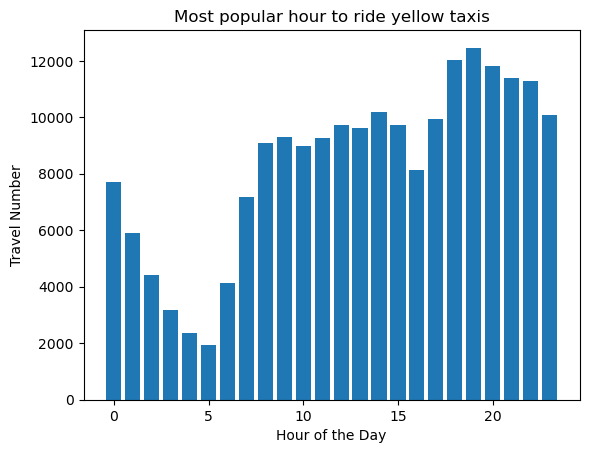

In [49]:
vis1_dataframe = get_data_for_visual_popular_hour()
plot_visual_popular_hour(vis1_dataframe)

### Visualization 2
- Create a visualization that shows the average distance traveled per month (regardless of year - so group by each month) for both taxis and Ubers combined. Include the 90% confidence interval around the mean in the visualization.

In [50]:
def plot_visual_average_distance(dataframe):
    """
    Plot data into graph of averaged distance traveled per month
    
    with 90% confidence level around the mean
    
    Arguments:
    dataframe -- data needed for graphing
    
    """
    day_list = []
    count_list = []
    ub_list = []
    lb_list = []
    for d in dataframe:
        day_list.append(d[0])
        count_list.append(d[1])
        ub_list.append(d[1]+math.sqrt(d[2]/d[3])*1.645)
        lb_list.append(d[1]-math.sqrt(d[2]/d[3])*1.645)
    plt.fill_between(day_list, ub_list, lb_list, alpha=.5, linewidth=0)
    plt.plot(day_list, count_list)
    plt.xlabel("Month")
    plt.ylabel("Average distance")
    plt.title("Average distance traveled per Month") 
    plt.show()

In [51]:
def get_data_for_visual_average_distance():
    """
    Write sql query and execute for needed data
    
    Returns:
    res -- data contains average distance, standard deviation, and count of trips of it per month
    
    """
    QUERY_V2 = '''
    WITH trip AS(
        SELECT MONTH, cal_distance as value
        FROM taxi_trips
        UNION ALL
        SELECT MONTH, cal_distance
        FROM uber_trips
    )
    SELECT MONTH, AVG(value), ((sum(value)*sum(value) - sum(value * value))/((count(*)-1)*(count(*)))), count(*) 
    FROM trip 
    GROUP BY MONTH 
    '''
    res = engine.execute(QUERY_V2).fetchall()
    return res

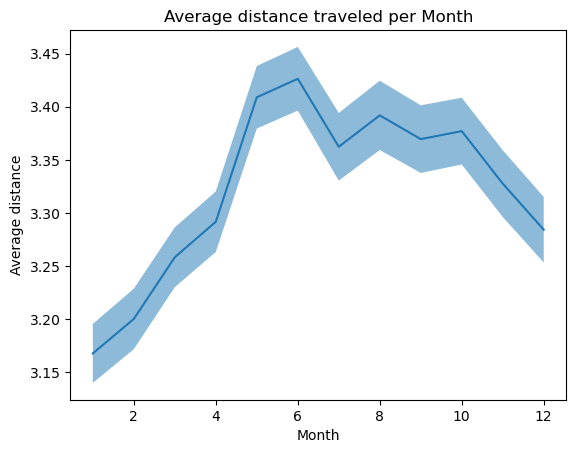

In [52]:
vis2_dataframe = get_data_for_visual_average_distance()
plot_visual_average_distance(vis2_dataframe)

### Visualization 3
- Define three lat/long coordinate boxes around the three major New York airports: LGA, JFK, and EWR (you can use bboxfinder to help). Create a visualization that compares what day of the week was most popular for drop offs for each airport. 

- Query steps:
- 1. By bboxfinder, we find latitude and longitude of LGA, JFK, and EWR
- 2. Select DAY, WEEK and compare distance of each data on LGA, JFK or EWR

In [53]:

def plot_visual_popular_dropoffs_day(df_LGA, df_JFK, df_EWR):
    """
    Plot data into graph for traffic flow to LGA, JFK, and EWR, sort into day of week
    
    Arguments:
    df_LGA -- data about LGA
    df_JFK -- data about JFK
    df_EWR -- data about EWR
    
    """
    LGA_day = []
    LGA_count = []
    for d in df_LGA:
        LGA_day.append(d[0])
        LGA_count.append(d[1])
    JFK_day = []
    JFK_count = []
    for d in df_JFK:
        JFK_day.append(d[0])
        JFK_count.append(d[1])
    EWR_day = []
    EWR_count = []
    for d in df_EWR:
        EWR_day.append(d[0])
        EWR_count.append(d[1])
    
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1)
    
    ax1.bar(LGA_day, LGA_count)
    ax1.set_title("Most popular day to go LGA")
    
    ax2.bar(JFK_day, JFK_count)
    ax2.set_title("Most popular day to go JFK")
    
    ax3.bar(EWR_day, EWR_count)
    ax3.set_title("Most popular day to go EWR")
    
    fig.text(0.5, -0.04, "days", ha="center", va="center")
    fig.text(-0.1, 0.5, "No. of trips", ha='center', va="center", rotation='vertical')
    fig.tight_layout()
    
    plt.show()

In [54]:
def get_data_for_visual_popular_dropoffs_day():
    """
    Write and execute sql query for traffic flow data about LGA, JFK, and EWR  
    
    Returns:
    res -- a list contains three set of data about above airports
    
    """
    #Coordinates of airports (from bboxfinder)
    #LGA_box_lat = [40.765396, 40.784441]
    #LGA_box_lng = [-73.900051, -73.858852]
    #JFK_box_lat = [40.624898, 40.664233]
    #JFK_box_lng = [-73.823318, -73.744526]
    #EWR_box_lat = [40.669572, 40.710247]
    #EWR_box_lng = [-74.191961, -74.153681]
    QUERY_LGA = """
    WITH trip AS(
        SELECT WEEK, dropoff_longitude as lng, dropoff_latitude as lat
        FROM taxi_trips
        UNION ALL
        SELECT WEEK, dropoff_longitude as lng, dropoff_latitude as lat
        FROM uber_trips
    )
    SELECT WEEK, COUNT(*) as number_of_trips
    FROM trip
    WHERE lat BETWEEN 40.765396 AND 40.784441 AND lng BETWEEN -73.900051 AND -73.858852
    GROUP BY WEEK
    """
    
    QUERY_JFK = """
    WITH trip AS(
        SELECT WEEK, dropoff_longitude as lng, dropoff_latitude as lat
        FROM taxi_trips
        UNION ALL
        SELECT WEEK, dropoff_longitude as lng, dropoff_latitude as lat
        FROM uber_trips
    )
    SELECT WEEK, COUNT(*) as number_of_trips
    FROM trip
    WHERE lat BETWEEN 40.624898 AND 40.664233 AND lng BETWEEN -73.823318 AND -73.744526
    GROUP BY WEEK
    """
    
    QUERY_EWR = """
    WITH trip AS(
        SELECT WEEK, dropoff_longitude as lng, dropoff_latitude as lat
        FROM taxi_trips
        UNION ALL
        SELECT WEEK, dropoff_longitude as lng, dropoff_latitude as lat
        FROM uber_trips
    )
    SELECT WEEK, COUNT(*) as number_of_trips
    FROM trip
    WHERE lat BETWEEN 40.669572 AND 40.710247 AND lng BETWEEN -74.191961 AND -74.153681
    GROUP BY WEEK
    """
    
    df_LGA = engine.execute(QUERY_LGA).fetchall()
    df_JFK = engine.execute(QUERY_JFK).fetchall()
    df_EWR = engine.execute(QUERY_EWR).fetchall()
    res = [df_LGA, df_JFK, df_EWR]
    return res

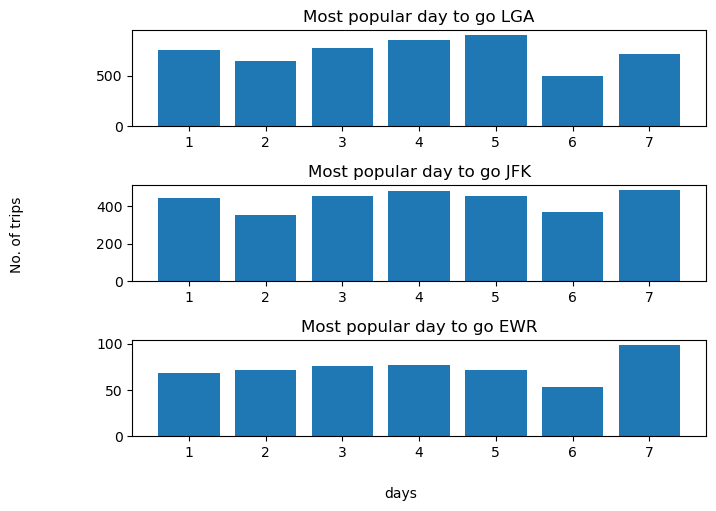

In [55]:
vis3_dflist = get_data_for_visual_popular_dropoffs_day()
plot_visual_popular_dropoffs_day(vis3_dflist[0], vis3_dflist[1], vis3_dflist[2])

### Visualization 4
- Create a heatmap of all hired trips over a map of the area. Consider using KeplerGL or another library that helps generate geospatial visualizations.

- Query steps:
- 1. Select taxi_trips and uber_trips
- 2. Return all pickup_lat, pickup_lon, dropoff_lat, dropoff_lon
- 3. Use KeplerGl to show all points

In [56]:
def plot_visual_all_trips_heatmap(df):
    """
    Use KeplerGl to graph data about all hired trips into heatmap
    
    Arguments:
    df -- data of all hired trips in NYC
    
    Returns:
    map -- a kepler object with data inside
    
    """
    map = KeplerGl(height=500)
    map.add_data(data=df, name='NYC hired trips heatmap')
    return map

In [57]:
def get_data_for_visual_all_trips_heatmap():
    """
    Write and execute sql query to get data about all hired trips in NYC

    Returns:
    res -- dataframe with data about all hired trips in NYC
    
    """
    QUERY_V4 = '''
     WITH trip AS(
        SELECT dropoff_longitude as lng, dropoff_latitude as lat
        FROM taxi_trips
        UNION ALL
        SELECT dropoff_longitude as lng, dropoff_latitude as lat
        FROM uber_trips
    )
    SELECT lat as Latitude, lng as Longitude
    FROM trip
    '''
    res1 = engine.execute(QUERY_V4).fetchall()
    res = pd.DataFrame(res1)
    return res

In [58]:
vis4_dataframe = get_data_for_visual_all_trips_heatmap()
map = plot_visual_all_trips_heatmap(vis4_dataframe)

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


In [59]:
map

KeplerGl(data={'NYC hired trips heatmap': {'index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,…

### Visualization 5
- Create a scatter plot that compares tip amount versus distance for Yellow Taxi rides. You may remove any outliers how you see fit.

- Query steps:
- 1. Select taxi_trips
- 2. Return tip_amount and cal_distance
- 3. Show scatter about tip_amount and cal_distance

In [60]:
def plot_visual_tip_distance(dataframe):
    """
    Plot data into scatter plot with tip amount(x axis) and distance(y axis) of taxi
    
    Arguments:
    dataframe -- data needed to graph
    
    """
    tip_list = []
    distance_list = []
    for d in dataframe:
        tip_list.append(d[0])
        distance_list.append(d[1])
    plt.scatter(tip_list, distance_list)
    plt.xlabel("tip_amount")
    plt.ylabel("distance")
    plt.title("Tip amount VS Distance")   
    plt.show()

In [61]:
def get_data_for_visual_tip_distance():
    """
    Write and execute data about tip within 0 and 50, and distance of taxi
    
    Returns:
    res -- data with above elements
    
    """
    QUERY_V5 = '''
    SELECT tip_amount, cal_distance
    FROM taxi_trips
    WHERE tip_amount between 0 AND 50 AND cal_distance between 0 and 200
    '''
    res = engine.execute(QUERY_V5).fetchall()
    return res

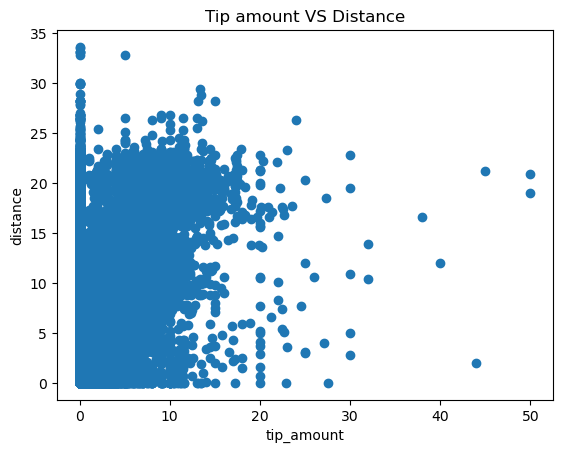

In [62]:
vis5_dataframe = get_data_for_visual_tip_distance()
plot_visual_tip_distance(vis5_dataframe)

### Visualization 6
- Create another scatter plot that compares tip amount versus precipitation amount for Yellow Taxi rides. You may remove any outliers how you see fit.

- Query steps:
- 1. Union taxi_trips and hourly_weather by hour column
- 2. Select taxi_trips.tip_amount and hourly_weather.hourly_precipitation
- 3. Show scatter tip_amount and hourly_precipitation

In [63]:
def plot_visual_tip_precipitation(dataframe):
    """
    Plot data into graph about tip of all hired trips and hourly precipitation in NYC
    
    Arguments:
    dataframe -- data contains above elements
    
    """
    tip_list = []
    rain_list = []
    for d in dataframe:
        tip_list.append(d[0])
        rain_list.append(d[1])
    plt.scatter(tip_list, rain_list)
    plt.xlabel("Tip")
    plt.ylabel("Precipitation amount")
    plt.title("Tip amount VS Precipitation amount")
    plt.show()

In [64]:
def get_data_for_visual_tip_precipitation():
    """
    Write and execute sql query for 1000 lines of data about tip amount and hourly precipitation
    
    Returns:
    res -- data contains above elements
    
    """
    #only get 1000 sample because size of all data is too large and breaks kernel
    QUERY_V6 = '''
    SELECT taxi_trips.tip_amount, hourly_weather.HourlyPrecipitation 
    FROM taxi_trips 
    LEFT JOIN hourly_weather ON taxi_trips.HOUR = hourly_weather.HOUR
    WHERE taxi_trips.tip_amount BETWEEN 0 AND 50
    ORDER BY RANDOM()
    LIMIT 1000
    '''
    res = engine.execute(QUERY_V6).fetchall()
    return res

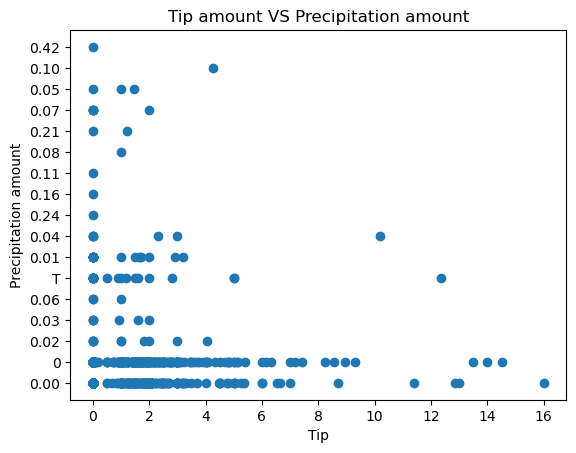

In [65]:
vis6_dataframe = get_data_for_visual_tip_precipitation()
plot_visual_tip_precipitation(vis6_dataframe)

# Extra Credit: Animation effect
1. Change code in visualization 5 to add animation effect
2. Call query of V5 and create animated scatter plot

In [66]:
def plot_anime_tip_distance1(dataframe):
    """
    Plot data into animation about part 4 visualization 5: tip amount versus distance
    
    Need to save it to gif for to view animation, Jupyter do not show the animation
    
    Arguments:
    dataframe -- data contains above element
    
    """
    tip_list = []
    distance_list = []
    for d in dataframe:
        tip_list.append(d[0])
        distance_list.append(d[1])
    tip_list = tip_list[:1000]
    distance_list = distance_list[:1000]
    fig, ax = plt.subplots()
    
    def animate(i):
        """
        Design animation
        
        Arguments:
        i -- number of order of frames
    
        """
        ax.clear()
        ax.scatter(tip_list, distance_list, linewidths=tan(i))
        ax.set_xlabel("tip_amount")
        ax.set_ylabel("distance")
        ax.set_title("Tip VS distance for Yellow Taxi")
    
    #export the animation as gif file because cannot display animation in python directly
    ani = animation.FuncAnimation(fig, animate, frames=10, interval = 100)
    ani.save("ec1.gif", writer="pillow")

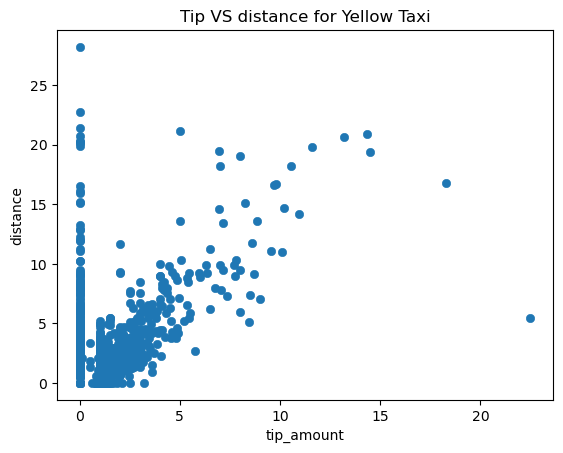

In [67]:
ani5_dataframe = get_data_for_visual_tip_distance()
plot_anime_tip_distance1(ani5_dataframe)

# Extra Credit: Sunset, Sunrise

In [68]:
def clean_month_weather_data_sun(csv_file):
    """
    Get and clean weather data with columns about date, sunrise, and sunset time
    
    Arguments:
    csv_file -- file name contains needed data
    
    Returns:
    sun_weather -- cleaned dataframe with above data
    
    """
    pd_data = pd.read_csv(csv_file, usecols=['DATE','Sunrise','Sunset'])
    pd_data.dropna(inplace=True)
    pd_data['DATE'] = pd.to_datetime(pd_data['DATE'])
    pd_data['YEAR'] = pd_data['DATE'].dt.year.astype(int)
    pd_data['MONTH'] = pd_data['DATE'].dt.month.astype(int)
    pd_data['DAY'] = pd_data['DATE'].dt.day.astype(int)
    pd_data['HOUR'] = pd_data['DATE'].dt.hour.astype(int)    
    pd_data["WEEK"] = pd_data['DATE'].dt.dayofweek+1  
    sun_weather = pd_data
    return sun_weather

In [69]:
def load_and_clean_weather_data():
    """
    Get and append data about date, sunset, and sunrise time from 2009 to 2015
    
    Returns:
    sun_data -- dataframe with above data
    
    """
    sun_dataframes = []

    for csv_file in WEATHER_CSV_FILES:
        sun_dataframe = clean_month_weather_data_sun(csv_file)
        sun_dataframes.append(sun_dataframe)
        
    # create two dataframes with hourly & daily data from every month
    sun_data = pd.concat(sun_dataframes)
    sun_data = sun_data.reset_index()
    sun_data.drop('index',axis=1, inplace=True)
    return sun_data

In [70]:
sun_weather = load_and_clean_weather_data()
sun_weather

,DATE,Sunrise,Sunset,YEAR,MONTH,DAY,HOUR,WEEK
0,2009-01-02 23:59:00,720.0,1640.0,2009,1,2,23,5
1,2009-01-06 23:59:00,720.0,1644.0,2009,1,6,23,2
2,2009-01-07 23:59:00,720.0,1645.0,2009,1,7,23,3
3,2009-01-10 23:59:00,720.0,1648.0,2009,1,10,23,6
4,2009-01-11 23:59:00,720.0,1649.0,2009,1,11,23,7
...,...,...,...,...,...,...,...,...
1821,2015-12-27 23:59:00,719.0,1635.0,2015,12,27,23,7
1822,2015-12-28 23:59:00,719.0,1636.0,2015,12,28,23,1
1823,2015-12-29 23:59:00,720.0,1636.0,2015,12,29,23,2
1824,2015-12-30 23:59:00,720.0,1637.0,2015,12,30,23,3


In [71]:
SUN_WEATHER_SCHEMA = """
CREATE TABLE IF NOT EXISTS Sun_weather
(
    id INTEGER PRIMARY KEY,
    DATE TIMESTAMP,
    YEAR INTEGER,
    MONTH INTEGER,
    DAY INTEGER,
    WEEK INTEGER,
    HOUR INTEGER,
    Sunrise FLOAT,
    Sunset FLOAT
);
"""
with open(DATABASE_SCHEMA_FILE, "a") as f:
    f.write(SUN_WEATHER_SCHEMA)
with engine.connect() as connection:
    connection.execute(SUN_WEATHER_SCHEMA)
    sun_weather.to_sql('Sun_weather', con=connection, if_exists='replace')

## For every month in the year, what is the average sunrise time and average traveled distance of yellow taxi during that month
Combine sql tables of yellow taxi and daily sunset/sunrise with query.

In [72]:
QUERY_EC = """
WITH trip AS (
    SELECT MONTH , AVG(cal_distance) as average_distance
    FROM taxi_trips
    GROUP BY MONTH
)
SELECT trip.MONTH, CAST(AVG(CAST(Sun_weather.Sunrise/100 AS int)) AS int) as Sunrise_Hour, 
       trip.average_distance as Average_Distance_for_taix_trips
FROM Sun_weather
LEFT JOIN trip ON Sun_weather.MONTH=trip.MONTH
GROUP BY trip.MONTH
"""

In [73]:
pd.DataFrame(engine.execute(QUERY_EC).fetchall())

,MONTH,Sunrise_Hour,Average_Distance_for_taix_trips
0,1,7,3.192296
1,2,6,3.208331
2,3,5,3.285681
3,4,4,3.283932
4,5,4,3.390551
5,6,4,3.464303
6,7,4,3.366142
7,8,4,3.397142
8,9,5,3.380730
9,10,5,3.403059


In [74]:
write_query_to_file(QUERY_EC, "Average sunrise hour and average taxi distance per month.sql")